In [7]:
#How to pick subjects: best psnr, median psnr, worst psnr
#Normalize bar charts by the highest in the dataset, for frequency, normalize to GT

#(vertical scaling would be [0,1] or [0.5,1] ,)



In [8]:
#using soup environment, python version 3.7.0
import numpy as np
import matplotlib.pyplot as plt

from utils.myutils import *
from pathlib import Path
from resize.scipy import resize
import nibabel as nib
from tqdm import tqdm
import pandas as pd


import image_similarity_measures
from image_similarity_measures.quality_metrics import ssim, psnr,issm,fsim
from vif.vif_utils import vif
import cpbd
import statistics

In [9]:
#load dataframes 
vif_df = pd.read_csv('iqm/normal_vif_df.csv')
ssim_df = pd.read_csv('iqm/normal_ssim_df.csv')
psnr_df = pd.read_csv('iqm/normal_psnr_df.csv')
cpbd_df = pd.read_csv('cpbd_df.csv')

In [10]:
cpbd_df.drop('Unnamed: 0', axis=1, inplace=True)
vif_df.drop('Unnamed: 0', axis=1, inplace=True)
vif_df.drop('Unnamed: 0.1', axis=1, inplace=True)
ssim_df.drop('Unnamed: 0', axis=1, inplace=True)
ssim_df.drop('Unnamed: 0.1', axis=1, inplace=True)
psnr_df.drop('Unnamed: 0', axis=1, inplace=True)
psnr_df.drop('Unnamed: 0.1', axis=1, inplace=True)

In [11]:
cpbd_df['IQM'] = ['CPBD']*10

In [12]:
vif_df.insert(0, 'GT', [0]*10)

In [13]:
psnr_df.insert(0, 'GT', [0]*10)
ssim_df.insert(0, 'GT', [0]*10)


In [14]:
vif_df['IQM'] = ['VIF']*10
ssim_df['IQM'] = ['SSIM']*10
psnr_df['IQM'] = ['PSNR']*10

In [15]:
df1 = cpbd_df

In [16]:
df2 = df1.append(psnr_df, ignore_index = True)

In [17]:
df3 = df2.append(ssim_df, ignore_index = True)
big_df = df3.append(vif_df, ignore_index = True)

In [18]:
max_ssim = big_df['SMORE'].iloc[25]
max_cpbd = big_df['GT'].iloc[9]
max_psnr = big_df['SMORE'].iloc[14]
max_vif = big_df['SMORE'].iloc[35]

In [19]:
from matplotlib import cycler
def set_display_mode(mode='dark', figsize=(16, 9), fontsize=18):
    plt.rcParams['figure.figsize'] = figsize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['image.cmap'] = 'Greys_r'
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['image.interpolation'] = 'nearest'
    if mode == 'dark':
        bg_color = 'black'
        fg_color = 'white'
    else:
        bg_color = 'white'
        fg_color = 'black'
    plt.rcParams['figure.facecolor'] = bg_color
    plt.rcParams['axes.facecolor'] = bg_color
    plt.rcParams['axes.edgecolor'] = fg_color
    plt.rcParams['axes.prop_cycle'] = cycler(color=[fg_color]) 
    plt.rcParams['text.color'] = fg_color
    plt.rcParams['axes.labelcolor'] = fg_color
    plt.rcParams['xtick.color'] = fg_color
    plt.rcParams['ytick.color'] = fg_color

In [20]:
import seaborn as sns

In [21]:
#load HR, soup and synthSR
hr_path = Path("/iacl/pg22/sam/data/OASIS3/OASIS3_iso/")
hr = list(hr_path.iterdir())
hr_list = hr[0:10]

#create hr_image list
hr_images = []
for hr in hr_list:
    im = nib.load(hr)
    hr_img = im.get_fdata(dtype=np.float32)
    hr_images.append(hr_img)

In [22]:
#kevin list
soup_path = Path("kevin_out")
soup_list = list(soup_path.iterdir())#right order

#synthSR list
synth_path = Path("SynthSR/output/")
synth_list = list(synth_path.iterdir())

In [24]:
from intensity_normalization.normalize.nyul import NyulNormalize
new_nyul_normalizer = NyulNormalize()
new_nyul_normalizer.load_standard_histogram("lr20.npy")

new_images = []
new_synths= []
for soup in soup_list:
    soup_arr = np.load(soup)
    new_images.append(soup_arr)
    
    
for synth in synth_list:
    synth_im = nib.load(synth)
    synth_img = synth_im.get_fdata(dtype=np.float32)
    new_synths.append(synth_img)

    
soup_normalized = [new_nyul_normalizer(image) for image in new_images]
synth_normalized = [new_nyul_normalizer(image) for image in new_synths]

reshape_synth = []
for s in synth_normalized:
    reshape_synth.append(s[0:176,0:256,0:256])

In [25]:
#smore list
sm_path = Path("/iacl/pg22/ashley/order_output/")
sm_list = list(sm_path.iterdir()) #order is not right
sm_images=[]

#rearrange sm_list manually
order = [2,1,7,5,4,8,3,6,0,9]

sm_ordered_list = []
for num in order:
    sm_ordered_list.append(sm_list[num])

    
for sm in sm_ordered_list:
    im = nib.load(sm)
    sm_img = im.get_fdata(dtype=np.float32)
    sm_images.append(sm_img)



In [26]:
lr_path = Path("/iacl/pg22/sam/data/OASIS3/OASIS3_LR/04-skip-00")
lr = list(lr_path.iterdir())
lr_list = lr[0:10]

In [27]:
lr_images = []
ratio = 256/64
for lr in lr_list:
    im = nib.load(lr)
    lr_img = im.get_fdata(dtype=np.float32)
    
    #lr resample
    lr_upsampled = resize(lr_img,dxyz=(1,1,1/ratio), order=3)
    lr_images.append(lr_upsampled)
    

In [28]:
#subjects: high: 4, median: 5, low: 7

In [29]:
new_hr = [hr_images[4],hr_images[5],hr_images[7]]
new_sm = [sm_images[4],sm_images[5],sm_images[7]]
new_lr = [lr_images[4],lr_images[5],lr_images[7]]
new_soup = [soup_normalized[4],soup_normalized[5],soup_normalized[7]]
new_synth = [reshape_synth[4],reshape_synth[5],reshape_synth[7]]

In [62]:
from matplotlib import cycler
def set_display_mode(mode='dark', figsize=(100, 25), fontsize=20):
    plt.rcParams['figure.figsize'] = figsize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['image.cmap'] = 'Greys_r'
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['image.interpolation'] = 'nearest'
    if mode == 'dark':
        bg_color = 'black'
        fg_color = 'white'
    else:
        bg_color = 'white'
        fg_color = 'black'
    plt.rcParams['figure.facecolor'] = bg_color
    plt.rcParams['axes.facecolor'] = bg_color
    plt.rcParams['axes.edgecolor'] = fg_color
    plt.rcParams['axes.prop_cycle'] = cycler(color=[fg_color]) 
    plt.rcParams['text.color'] = fg_color
    plt.rcParams['axes.labelcolor'] = fg_color
    plt.rcParams['xtick.color'] = fg_color
    plt.rcParams['ytick.color'] = fg_color

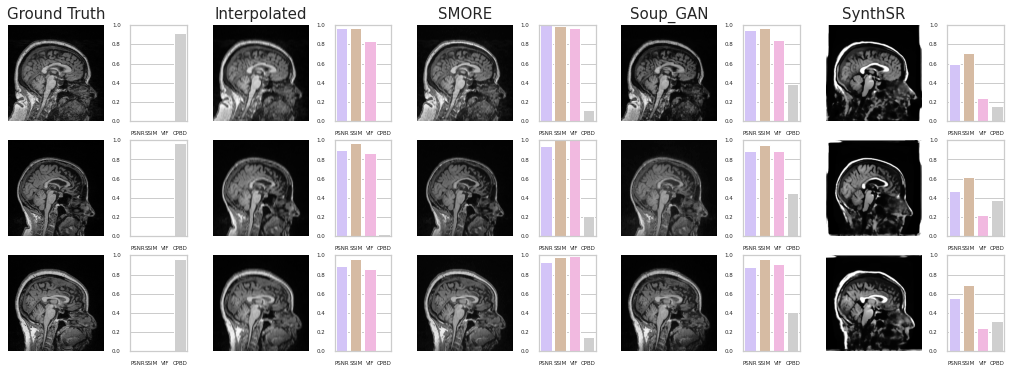

In [70]:
pal = sns.color_palette("pastel")
sns.set_theme(style="whitegrid",palette=pal[4:],font_scale=0.5)


#fig = plt.figure(figsize=(25, 10))
rows = 3
columns = 10
#text_size = 10

titles = ['Ground Truth', '', 'Interpolated','','SMORE','','Soup_GAN','','SynthSR']
#labeling y axis
fig,axes = plt.subplots(rows, columns,figsize=(18, 6),gridspec_kw={'width_ratios': [2, 1,2,1,2,1,2,1,2,1]})


order = [4,5,7]
#HR
for count,num in enumerate(order):
    hr1_df = pd.DataFrame(index = range(0,4),columns=['IQM','Data'])
    hr1_df.iloc[0] = ['PSNR',0]
    hr1_df.iloc[1] = ['SSIM',0]
    hr1_df.iloc[2] = ['VIF',0]
    hr1_df.iloc[3] = ['CPBD',cpbd_df['GT'][num] / max_cpbd]
    
    axes[count,0].imshow(np.rot90(new_hr[count][88,:,:]),cmap="Greys_r")
    axes[count,0].axis('off')
    if(count == 0):
        axes[count,0].set_title('Ground Truth',fontsize=15)
    sns.barplot(x="IQM", y="Data", data=hr1_df,ax=axes[count,1])
    axes[count,1].set_ylim(0,1)
    axes[count,1].set(xlabel=None)
    axes[count,1].set(ylabel=None)

#LR
for count,num in enumerate(order):
    hr1_df = pd.DataFrame(index = range(0,4),columns=['IQM','Data'])
    hr1_df.iloc[0] = ['PSNR',psnr_df['Interpolated'][num] / max_psnr]
    hr1_df.iloc[1] = ['SSIM',ssim_df['Interpolated'][num] / max_ssim]
    hr1_df.iloc[2] = ['VIF',vif_df['Interpolated'][num] / max_vif]
    hr1_df.iloc[3] = ['CPBD',cpbd_df['Interpolated'][num] / max_cpbd]
 
    axes[count,2].imshow(np.rot90(new_lr[count][88,:,:]),cmap="Greys_r")
    axes[count,2].axis('off')
    if(count == 0):
        axes[count,2].set_title('Interpolated',fontsize=15)
    sns.barplot(x="IQM", y="Data", data=hr1_df,ax=axes[count,3])
    axes[count,3].set_ylim(0,1)
    axes[count,3].set(xlabel=None)
    axes[count,3].set(ylabel=None)
#Smore
for count,num in enumerate(order):
    hr1_df = pd.DataFrame(index = range(0,4),columns=['IQM','Data'])
    hr1_df.iloc[0] = ['PSNR',psnr_df['SMORE'][num] / max_psnr]
    hr1_df.iloc[1] = ['SSIM',ssim_df['SMORE'][num] / max_ssim]
    hr1_df.iloc[2] = ['VIF',vif_df['SMORE'][num] / max_vif]
    hr1_df.iloc[3] = ['CPBD',cpbd_df['SMORE'][num] / max_cpbd]
 
    axes[count,4].imshow(np.rot90(new_sm[count][88,:,:]),cmap="Greys_r")
    axes[count,4].axis('off')
    if(count == 0):
        axes[count,4].set_title('SMORE',fontsize=15)
    sns.barplot(x="IQM", y="Data", data=hr1_df,ax=axes[count,5])
    axes[count,5].set_ylim(0,1)
    axes[count,5].set(xlabel=None)
    axes[count,5].set(ylabel=None)
#Soup
for count,num in enumerate(order):
    hr1_df = pd.DataFrame(index = range(0,4),columns=['IQM','Data'])
    hr1_df.iloc[0] = ['PSNR',psnr_df['Soup_GAN'][num] / max_psnr]
    hr1_df.iloc[1] = ['SSIM',ssim_df['Soup_GAN'][num] / max_ssim]
    hr1_df.iloc[2] = ['VIF',vif_df['Soup_GAN'][num] / max_vif]
    hr1_df.iloc[3] = ['CPBD',cpbd_df['Soup_GAN'][num] / max_cpbd]
 
    axes[count,6].imshow(np.rot90(new_soup[count][88,:,:]),cmap="Greys_r")
    axes[count,6].axis('off')
    if(count == 0):
        axes[count,6].set_title('Soup_GAN',fontsize=15)
    sns.barplot(x="IQM", y="Data", data=hr1_df,ax=axes[count,7])
    axes[count,7].set_ylim(0,1)
    axes[count,7].set(xlabel=None)
    axes[count,7].set(ylabel=None)
#synth
for count,num in enumerate(order):
    hr1_df = pd.DataFrame(index = range(0,4),columns=['IQM','Data'])
    hr1_df.iloc[0] = ['PSNR',psnr_df['SynthSR'][num] / max_psnr]
    hr1_df.iloc[1] = ['SSIM',ssim_df['SynthSR'][num] / max_ssim]
    hr1_df.iloc[2] = ['VIF',vif_df['SynthSR'][num] / max_vif]
    hr1_df.iloc[3] = ['CPBD',cpbd_df['SynthSR'][num] / max_cpbd]
    
    axes[count,8].imshow(np.rot90(new_synth[count][88,:,:]),cmap="Greys_r")
    axes[count,8].axis('off')
    if(count == 0):
        axes[count,8].set_title('SynthSR',fontsize=15)
    sns.barplot(x="IQM", y="Data", data=hr1_df,ax=axes[count,9])
    axes[count,9].set_ylim(0,1)
    axes[count,9].set(xlabel=None)
    axes[count,9].set(ylabel=None)

#plt.subplots_adjust(wspace=0, hspace=0.4)
plt.savefig('images/figure2.png',dpi=300)


In [ ]:
name

In [ ]:
fig.add_subplot(ax=axes[0,0])
# showing image
plt.imshow(np.rot90(new_hr[0][88,:,:]),cmap="Greys_r")
plt.axis('off')

#plt.title("Ground Truth",size=text_size)

fig.add_subplot(rows, columns, 2)
# showing image

ax = sns.barplot(x="IQM", y="Data", data=hr1_df)
plt.ylim(0.5, 1)

fig.add_subplot(rows, columns, 3)
# showing image
plt.imshow(np.rot90(new_hr[1][88,:,:]),cmap="Greys_r")
plt.axis('off')
#plt.title("Ground Truth",size=text_size)

fig.add_subplot(rows, columns, 4)
# showing image

ax = sns.barplot(x="IQM", y="Data", data=hr2_df)
plt.ylim(0.5, 1)

fig.add_subplot(rows, columns, 5)
# showing image
plt.imshow(np.rot90(new_hr[2][88,:,:]),cmap="Greys_r")
plt.axis('off')
#plt.title("Ground Truth",size=text_size)

fig.add_subplot(rows, columns, 6)
# showing image
ax = sns.barplot(x="IQM", y="Data", data=hr3_df)
plt.ylim(0.5, 1)


#lr
fig.add_subplot(rows, columns, 7)
# showing image
plt.imshow(np.rot90(new_lr[0][88,:,:]),cmap="Greys_r")
plt.axis('off')
#plt.title("Interpolated",size=text_size)

fig.add_subplot(rows, columns, 8)
# showing image

ax = sns.barplot(x="IQM", y="Data", data=lr1_df)
plt.ylim(0.5, 1)

fig.add_subplot(rows, columns, 9)
# showing image
plt.imshow(np.rot90(new_lr[1][88,:,:]),cmap="Greys_r")
plt.axis('off')
#plt.title("Interpolated",size=text_size)

fig.add_subplot(rows, columns, 10)
# showing image

ax = sns.barplot(x="IQM", y="Data", data=lr2_df)
plt.ylim(0.5, 1)

fig.add_subplot(rows, columns, 11)
# showing image
plt.imshow(np.rot90(new_lr[2][88,:,:]),cmap="Greys_r")
plt.axis('off')
#plt.title("Interpolated",size=text_size)

fig.add_subplot(rows, columns, 12)
# showing image
ax = sns.barplot(x="IQM", y="Data", data=lr3_df)
plt.ylim(0.5, 1)

#bigger picture, chart smaller
#put lable on horizonal axis
#change color palette

#normalized based on max in 40 subjects (four maxs)

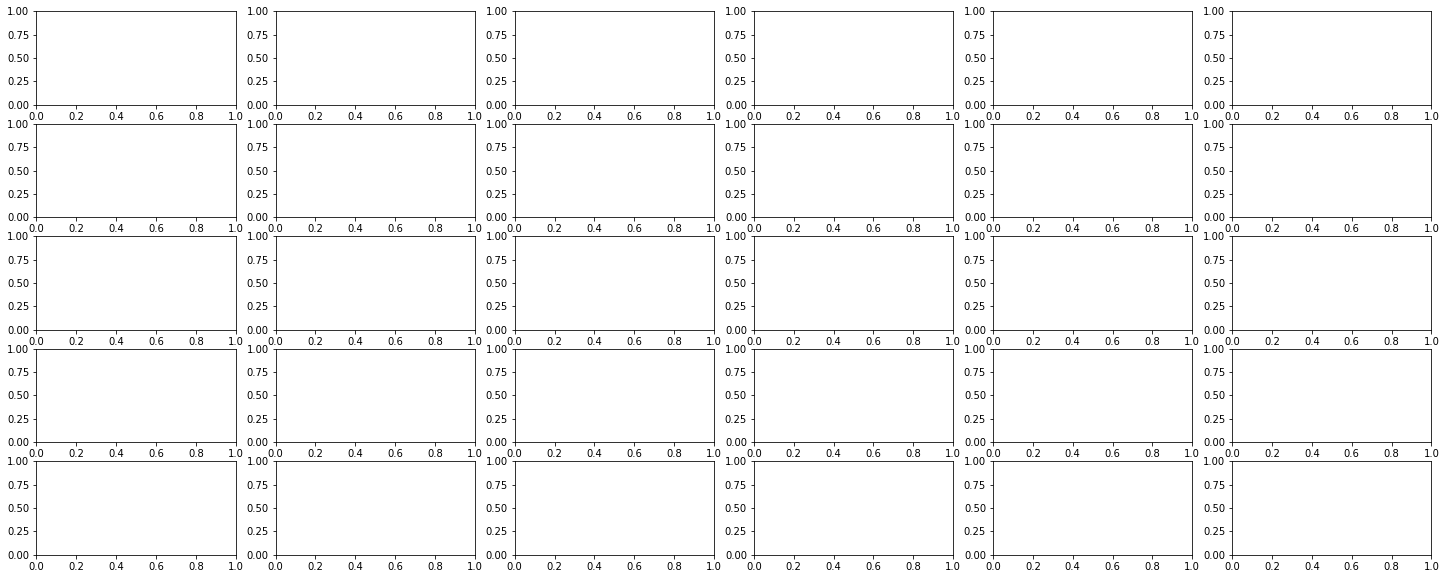

In [5]:
fig, axes = plt.subplots(5, 6, figsize=(25, 10))


In [6]:
sns.boxplot(ax=axes[0, 0], data=pokemon, x='Generation', y='Attack')

NameError: name 'sns' is not defined

In [ ]:
sub1_df = pd.DataFrame(index = range(0,10),columns=['Data','Type','Method'])

In [ ]:
#subjects: high: 4, low: 7, median: 5

sub1 = 